In [1]:
import sys
sys.path.append('../..')
from datamodules.mnist import MnistDataset
from core.trainer import Trainer
from models import CNN
from models import MNIST_CONFIG as config
import torch # type: ignore
import numpy as np # type: ignore
from matplotlib import pyplot as plt # type: ignore
from core import project_root
projroot = project_root()
import warnings
warnings.filterwarnings("ignore")

DATA SAVED!
N Examples: 54000
N Classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
 - Class 0: 5341 (9.89074074074074)
 - Class 1: 6098 (11.292592592592593)
 - Class 2: 5369 (9.942592592592593)
 - Class 3: 5521 (10.224074074074075)
 - Class 4: 5277 (9.772222222222222)
 - Class 5: 4866 (9.011111111111111)
 - Class 6: 5304 (9.822222222222223)
 - Class 7: 5607 (10.383333333333333)
 - Class 8: 5286 (9.788888888888888)
 - Class 9: 5331 (9.872222222222222)
MODEL LOADED!


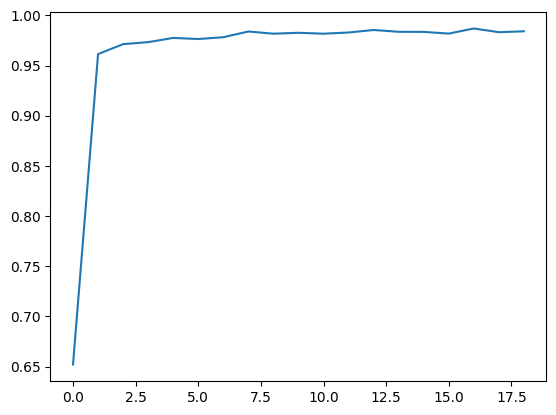

In [2]:
dataset = MnistDataset(tobeloaded=False, params=config.DATA_PARAMS)
dataset.summarize()
model = CNN("mnist", num_classes=10)
trainer = Trainer(params=config.TRAIN_PARAMS)
model.load("mnist")
# trainer.fit(model,dataset)
plt.plot(model.test_scores, label=f'mnist - test scores')

# Install

### [Getting Started](https://pytorch.org/executorch/stable/getting-started-setup.html)
### [Building with CMake](https://pytorch.org/executorch/stable/runtime-build-and-cross-compilation.html)

# Toy Example 
### [PyTorch Source](https://pytorch.org/executorch/stable/tutorials/export-to-executorch-tutorial.html)
### [Explanation of the three phases](https://pytorch.org/executorch/stable/ir-exir.html)

![picture 1](images/workflow.png)

In [3]:
import torch.nn as nn # type: ignore

class FullyConnected(torch.nn.Module):
    #Fully Connected layers    
    def __init__(self):
        super().__init__()
        fc_dims = [4,1]
        self.activation = nn.ReLU()
        self.example_args = (torch.randn(1, 4),)
        fc_layers = []
        for i in range(len(fc_dims)-1):
            fc_layers.append(nn.Linear(fc_dims[i],fc_dims[i+1],bias=True))
            fc_layers.append(self.activation)
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        return self.fc(x)
    
class Add(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.example_args = (torch.randn(1, 4), torch.randn(1, 4))
        
    def forward(self,x,y):
        return x + y
    
# m = FullyConnected()
m = CNN("mnist",num_classes=10)
m.load("mnist")
m.eval()
torch.no_grad()
m(*m.example_args)

MODEL LOADED!


tensor([[0.0020, 0.1363, 0.0000, 0.0000, 0.0897, 0.0000, 0.0000, 0.0000, 0.0174,
         0.0380]], grad_fn=<ReluBackward0>)

1) Core ATen Dialect
- [export()](https://pytorch.org/docs/2.1/export.html#torch.export.export) takes an arbitrary Python callable (an nn.Module, a function or a method) and produces a traced graph representing only the Tensor computation of the function in an Ahead-of-Time (AOT) fashion, which can subsequently be executed with different outputs or serialized. 
- The traced graph does three things 
    1) produces a normalized operator set consisting only of functional [Core ATen Operator Set](https://pytorch.org/docs/2.1/torch.compiler_ir.html) and user specified custom operators
    2) has eliminated all Python control flow and data structures (except for certain conditions)
    3) has the set of shape constraints needed to show that this normalization and control flow elimination is sound for a future input.
- We will print the graph, represented through [Torch Fx](https://pytorch.org/docs/stable/fx.html#module-torch.fx), in a table to explicitly represent inputs, operations and outputs (more info [here](https://pytorch.org/docs/stable/fx.html#torch.fx.Node))
- Internally, what happens is that we first convert to Pre-Autograd ATen Dialect
    - Trace a module before any pre-autograd decomposition is run.
    - Tracing means converting a PyTorch model into a more efficient, serialized format suitable for deployment in production or environments where Python might not be available.
        ```
        from torch._export import capture_pre_autograd_graph
        pre_autograd_aten_dialect = capture_pre_autograd_graph(m, m.example_args)
        ```
- Somewhere (it is not clear if before or after the aten dialect) we quantize
    - Lower the precision, maintaining the accuracy high enough
    - Goal is to enhance memory and computational efficiency
        ```
        from torch.ao.quantization.quantize_pt2e import convert_pt2e, prepare_pt2e
        from torch.ao.quantization.quantizer.xnnpack_quantizer import (
            get_symmetric_quantization_config,
            XNNPACKQuantizer,
        )

        quantizer = XNNPACKQuantizer().set_global(get_symmetric_quantization_config())
        prepared_graph = prepare_pt2e(pre_autograd_aten_dialect, quantizer)
        converted_graph = convert_pt2e(prepared_graph)
        ```

In [4]:
from torch.export import export, ExportedProgram # type: ignore
aten_dialect: ExportedProgram = export(m, m.example_args)
aten_dialect.graph.print_tabular()

opcode         name                       target                                args                                                                 kwargs
-------------  -------------------------  ------------------------------------  -------------------------------------------------------------------  --------
placeholder    arg0_1                     arg0_1                                ()                                                                   {}
placeholder    arg1_1                     arg1_1                                ()                                                                   {}
placeholder    arg2_1                     arg2_1                                ()                                                                   {}
placeholder    arg3_1                     arg3_1                                ()                                                                   {}
placeholder    arg4_1                     arg4_1                              

2) Edge Dialect
- to_edge() returns an EdgeProgramManager object, which contains the exported programs which will be placed on this device
    - DType specialization (to reduce binary size)
    - Scalar to tensor conversion
    - Converting all ops to the executorch.exir.dialects.edge namespace

In [5]:
from executorch.exir import EdgeProgramManager, to_edge # type: ignore
edge_program: EdgeProgramManager = to_edge(aten_dialect)
# to_be_lowered_module = edge_program.exported_program()
# to_be_lowered_module.graph.print_tabular()

3. Delegate to a Backend (optional)

In [6]:
from executorch.exir.backend.backend_api import LoweredBackendModule, to_backend # type: ignore
from executorch.exir.backend.test.backend_with_compiler_demo import (  # noqa # type: ignore
    BackendWithCompilerDemo,
)

4. Executorch Program

In [7]:
from executorch.exir import ExecutorchBackendConfig, ExecutorchProgramManager # type: ignore

executorch_program: ExecutorchProgramManager = edge_program.to_executorch(
        ExecutorchBackendConfig(
                # passes=[],  # User-defined passes
        )
)

print("ExecuTorch Dialect")
print(executorch_program.exported_program().graph.print_tabular())

with open(f"model.pte", "wb") as file:
    file.write(executorch_program.buffer)

ExecuTorch Dialect
opcode         name                                    target                              args                                                                 kwargs
-------------  --------------------------------------  ----------------------------------  -------------------------------------------------------------------  ------------------------------------
placeholder    arg0_1                                  arg0_1                              ()                                                                   {}
placeholder    arg1_1                                  arg1_1                              ()                                                                   {}
placeholder    arg2_1                                  arg2_1                              ()                                                                   {}
placeholder    arg3_1                                  arg3_1                              ()                                   